# Modelado

In [468]:
# Bibliotecas para Modelos de Machine Learning
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

# Bibliotecas para Manipulación de Datos y Análisis
import pandas as pd  # Manipulación de datos
import numpy as np  # Cálculo numérico

# Reducción de Dimensionalidad
from sklearn.decomposition import PCA

# Evaluación de Modelos
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

# Búsqueda de Hiperparámetros y Validación Cruzada
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline  # Creación de pipelines

# Otras Bibliotecas
import joblib  # Serialización de modelos
import matplotlib.pyplot as plt  # Visualización

## Funciones para entrenamiento y testeo

In [469]:
def grid_search_function(model, param_grid, X_train, y_train, pca_components=[0.50, 0.99], cv=2):
    """
    Realiza una búsqueda en cuadrícula (grid search) con validación cruzada
    para encontrar los mejores parámetros de un modelo de aprendizaje automático.

    Parámetros:
    - model: El modelo de aprendizaje automático a utilizar.
    - param_grid (dict): Diccionario de parámetros a probar en la búsqueda en cuadrícula.
    - X_train (array-like): Datos de entrenamiento.
    - y_train (array-like): Etiquetas de entrenamiento.
    - pca_components (list, opcional): Lista de componentes principales (PCA) a probar.
      Predeterminado: [0.50, 0.99]
    - cv (int, opcional): Número de divisiones para la validación cruzada. Predeterminado: 2.

    Retorna:
    tuple: Una tupla que contiene los mejores parámetros, la mejor puntuación,
    el mejor estimador y los resultados de la validación cruzada.
    """
    # Configura el pipeline con las funciones de PCA y el modelo de aprendizaje automático
    pipeline = Pipeline([
        ('pca', PCA()),
        ('classify', model)
    ])

    # Realiza la búsqueda en cuadrícula con validación cruzada utilizando el pipeline anterior
    # y los parámetros del modelo específico
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Obtiene los mejores parámetros del modelo específico
    best_params = grid_search.best_params_

    # Elimina el prefijo 'classify__' de todas las claves
    best_params = {key.replace('classify__', '', 1): value for key, value in best_params.items()}

    return best_params

In [470]:
def train(model, best_params=None):
    """
    Entrena un modelo de aprendizaje automático, opcionalmente utilizando los mejores
    parámetros obtenidos de una búsqueda en cuadrícula (grid search).

    Parámetros:
    - model: El modelo de aprendizaje automático a entrenar.
    - best_params (dict, opcional): Diccionario con los mejores parámetros para el modelo.
      Si no se proporciona, se entrenará el modelo con los parámetros predeterminados.

    Retorna:
    - El modelo entrenado.
    """
    # Si se proporcionan los mejores parámetros, se establecen en el modelo
    if best_params is not None:
        model.set_params(**best_params)

    # Entrena el modelo con los datos de entrenamiento
    return model.fit(X_train, y_train)

In [471]:
def test(model, is_classification=False):
    """
    Evalúa el rendimiento de un modelo de aprendizaje automático en un conjunto de prueba.
    Puede manejar tanto modelos de clasificación como de regresión.

    Parámetros:
    - model: El modelo de aprendizaje automático a evaluar.
    - is_classification (bool, opcional): Indica si el modelo es de clasificación.
      Predeterminado: False (regresión).

    Retorna:
    - y_pred: Las predicciones del modelo en el conjunto de prueba.
    """
    # Realiza las predicciones del modelo en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Si el modelo es de clasificación, calcula y muestra la precisión
    if is_classification:
        acc = accuracy_score(y_test, y_pred)
        print(f"Precisión del modelo: {acc}")
    # Si el modelo es de regresión, calcula y muestra el error cuadrático medio y el R²
    else:
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f'Error Cuadrático Medio en el conjunto de prueba: {mse:.2f}')
        print(f'Coeficiente de Determinación (R²): {r2:.2f}')

    return y_pred

In [472]:
def build_model(hp):
    model = Sequential()
    # Añadimos una capa de entrada con el tamaño del input_shape definido en el dataset
    model.add(layers.Input(shape=(input_shape,)))
    
    # Selecciona el número de capas ocultas (1 a 3)
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tamaño de la capa oculta (32 a 512, potencias de 2)
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh', 'leaky_relu'])
        ))
        # Posible dropout para regularización
        if hp.Boolean(f'use_dropout_{i}'):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)))
    
    # Capa de salida (1 unidad para regresión, num_classes para clasificación)
    if task == "regression":
        model.add(layers.Dense(1, activation='linear'))
        loss = 'mse'
        metrics = ['mae']
    elif task == "classification":
        model.add(layers.Dense(num_classes, activation='sigmoid'))
        loss = 'binary_crossentropy'
        metrics = ['accuracy', 'Precision']

    # Compilación del modelo
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.009, 0.09, 0.9])
        ),
        loss=loss,
        metrics=metrics
    )
    return model

In [473]:
def train_test_val_split(X_df:pd.DataFrame, y_df:pd.DataFrame):
    # Divido las variable target y el resto de variables en testeo y prueba 
    # 1. Para el subconjunto de entrenamiento se utiliza un 80% de los datos
    # 2. Para el subconjunto de prueba se utiliza un 20% de los datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    # Divido las variable target y el resto de variables en los conjuntos de prueba en dos subconjuntos
    # 1. Subconjunto de prueba urilizando un 50% para cada sub conjunto
    # 2. Subconjunto de validacion urilizando un 50% para cada sub conjunto
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

    return X_train, X_test, X_val, y_train, y_test, y_val

### Importacion de datos

In [474]:
path_df_estandarizado_escalado = '../data/silver/df_estandarizado_escalado.csv'
df_estandarizado_escalado = pd.read_csv(path_df_estandarizado_escalado)

In [475]:
df_estandarizado_escalado = df_estandarizado_escalado.sample(frac=1, random_state=12)

### Separacion de datos

In [476]:
# separo las las variables de la variable target
X = df_estandarizado_escalado.drop(columns=['subscribed_encoded'])
y = df_estandarizado_escalado['subscribed_encoded']

In [477]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X_df=X, y_df=y)

### Instancia y evaluacion de modelos

#### Bagging

**Modelo 1: Bosques aleatorios:**

In [478]:
# creo instancia del modelo random forest
random_forest_model = RandomForestClassifier()

# Parametros y rango de valores para el modelo de random forest
random_forest_params_grid = {
    'classify__max_depth': [None, 5, 10],
    'classify__min_samples_split': [2, 5, 10],
    'classify__min_samples_leaf': [1, 2, 4],
    'classify__ccp_alpha': [0.0, 0.1, 0.2]
}

In [479]:
# obtengo los mejores parametros desde grid search
random_forest_best_params_grid = grid_search_function(model= random_forest_model, param_grid=random_forest_params_grid, X_train=X_train, y_train=y_train)

In [480]:
# entreno el modelo con los mejores parametros previamente obtenidos
random_forest_model = train(random_forest_model, random_forest_best_params_grid)

In [481]:
# obtengo las predicciones del modelo
y_pred = test(random_forest_model, is_classification=True)

Precisión del modelo: 0.9011896091284293


**Modelo 2: Extra Trees**

In [482]:
# instancia del modelo extratrees
extra_trees_model = ExtraTreesClassifier()

# Define los parámetros a optimizar
extra_trees_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__max_depth': [None, 10, 20],
    'classify__min_samples_split': [2, 5],
    'classify__min_samples_leaf': [1, 2],
    'classify__max_features': ['auto', 'sqrt'],
    'classify__bootstrap': [False, True]
}

In [483]:
extra_trees_best_params_grid = grid_search_function(model= extra_trees_model, param_grid=extra_trees_params_grid, X_train=X_train, y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
62 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-pack

In [484]:
extra_trees_model = train(model=extra_trees_model, best_params=extra_trees_best_params_grid)

In [485]:
y_pred = test(model=extra_trees_model, is_classification=True)

Precisión del modelo: 0.9009468317552805


#### Boosting

**Modelo 1: AdaBoost**

In [486]:
# Define el modelo base y el modelo AdaBoost
base_estimator = DecisionTreeClassifier()
AdaBoostClassifier_model = AdaBoostClassifier(estimator=base_estimator)

# Define los parámetros a optimizar
ada_boost_params_grid = {
    'classify__n_estimators': [50, 100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'classify__estimator__max_depth': [1, 2, 3],
    'classify__algorithm': ['SAMME', 'SAMME.R']
}

In [487]:
ada_boost_best_params_grid = grid_search_function(model=AdaBoostClassifier_model, param_grid=ada_boost_params_grid, X_train=X_train,y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

In [488]:
AdaBoostClassifier_model = train(model=AdaBoostClassifier_model, best_params=ada_boost_best_params_grid)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [489]:
y_pred = test(model=AdaBoostClassifier_model, is_classification=True)

Precisión del modelo: 0.9036173828599174


**Modelo 2: XGBoost**


In [490]:
# Definir el modelo
xgb_model = xgb.XGBClassifier()

# Definir el grid de parámetros
xgb_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.2],
    'classify__max_depth': [3, 5, 7],
    'classify__subsample': [0.8, 1.0],
    'classify__colsample_bytree': [0.8, 1.0]
}

In [491]:
xgb_best_params_grid = grid_search_function(model= xgb_model, param_grid=xgb_params_grid, X_train=X_train, y_train=y_train)

In [492]:
xgb_model = train(model=xgb_model, best_params=xgb_best_params_grid)

In [493]:
y_pred = test(model=extra_trees_model, is_classification=True)

Precisión del modelo: 0.9009468317552805


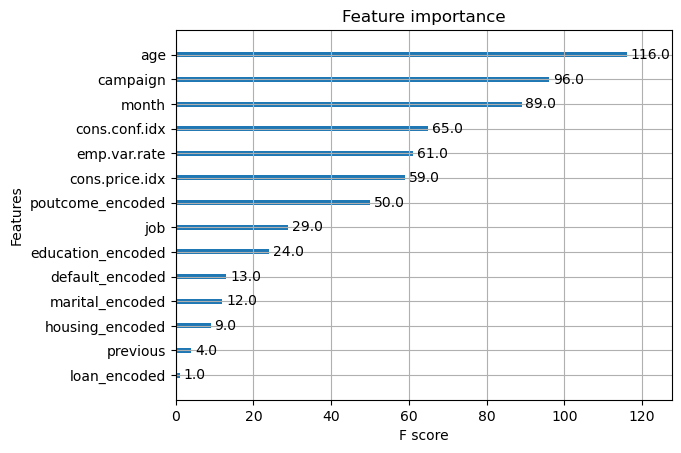

In [494]:
# Importancia de las características
xgb.plot_importance(xgb_model)
plt.show()

**Modelo 3: Stochastic Gradient Boosting**

In [495]:
# Definir el modelo
sgb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de parámetros
sgb_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.2],
    'classify__max_depth': [3, 4, 5],
    'classify__subsample': [0.8, 1.0]
}

In [496]:
sgb_best_params_grid = grid_search_function(model= sgb_model, param_grid=sgb_params_grid, X_train=X_train, y_train=y_train)

In [497]:
xgb_model = train(model=xgb_model, best_params=xgb_best_params_grid)

In [498]:
y_pred = test(model=extra_trees_model, is_classification=True)

Precisión del modelo: 0.9009468317552805


#### Vooting

**Modelo 1: Hard Voting:**

In [499]:
# Crear un VotingClassifier con hard voting
voting_clf_hard_model = VotingClassifier(estimators=[('rf', random_forest_model), ('xgb', xgb_model)],
                              voting='hard') 

In [500]:
voting_clf_hard_model = train(model= voting_clf_hard_model)

In [501]:
y_pred = test(model=voting_clf_hard_model, is_classification=True)

Precisión del modelo: 0.9031318281136198


**Modelo 2: Soft Voting**

In [502]:
voting_clf_soft_model = VotingClassifier(estimators=[('rf', random_forest_model), ('xgb', xgb_model)],
                              voting='soft',
                              weights=[1, 1]) 

In [503]:
voting_clf_soft_model = train(model= voting_clf_soft_model)

In [504]:
y_pred = test(model=voting_clf_soft_model, is_classification=True)

Precisión del modelo: 0.9033746054867686


### Deep learning

#### DNN

*Construccion de la RNA*

In [505]:
# Configura el hiperparámetro de entrada
input_shape = X_train.shape[1]  # Cambia esto al número de características en tu dataset
task = "classification"  # O usa "regression" si tu tarea es de regresión
num_classes = 1  # Cambia esto al número de clases (para clasificación)

# Define el tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy' if task == "classification" else 'val_mae',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='keras_tuner_demo'
)

# Callback para early stopping
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Realiza la búsqueda de hiperparámetros
tuner.search(X_train, 
            y_train, 
            epochs=16, 
            validation_data=(X_val, y_val), 
            callbacks=[stop_early],
            batch_size=32)

# Obtén los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Mejores hiperparámetros:
Número de capas ocultas: {best_hps.get('num_layers')}
Activación: {best_hps.get('activation')}
Unidades por capa: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
Dropout: {[best_hps.get(f'use_dropout_{i}') for i in range(best_hps.get('num_layers'))]}
Learning rate: {best_hps.get('learning_rate')}
""")

# Construye el modelo con los mejores hiperparámetros
best_model = tuner.hypermodel.build(best_hps)

# Entrena el modelo con los mejores hiperparámetros
best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Reloading Tuner from my_dir/keras_tuner_demo/tuner0.json

Mejores hiperparámetros:
Número de capas ocultas: 2
Activación: leaky_relu
Unidades por capa: [128, 32]
Dropout: [False, False]
Learning rate: 0.009

Epoch 1/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 796us/step - Precision: 0.5616 - accuracy: 0.8902 - loss: 0.3273 - val_Precision: 0.7024 - val_accuracy: 0.9017 - val_loss: 0.2740
Epoch 2/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - Precision: 0.6463 - accuracy: 0.8911 - loss: 0.3019 - val_Precision: 0.4477 - val_accuracy: 0.8847 - val_loss: 0.2873
Epoch 3/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - Precision: 0.6027 - accuracy: 0.8919 - loss: 0.2915 - val_Precision: 0.6475 - val_accuracy: 0.9022 - val_loss: 0.2730
Epoch 4/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - Precision: 0.6710 - accuracy: 0.8946 - loss: 0.2927 - val_Precision: 0.6260 - val_accuracy: 0.9014 - val_loss: 0.2754
Epoch 5/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - Precision: 0.6593 - accuracy: 

*Predicción con el subconjunto de datos de pruebas*

In [506]:
error, accuracy, precision = best_model.evaluate(X_test, y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - Precision: 0.8045 - accuracy: 0.9009 - loss: 0.2841 


In [507]:
print("Error: ", error)
print("Accuracy: ", accuracy)
print("Precision: ", precision)

Error:  0.27437660098075867
Accuracy:  0.90288907289505
Precision:  0.7831325531005859


### Guardado del mejor modelo

In [508]:
# Guardar el modelo entrenado en un archivo .pkl
path_best_one_ml_model = '../models/voting_clf_soft_model.pkl'
joblib.dump(voting_clf_soft_model, path_best_one_ml_model)

['../models/voting_clf_soft_model.pkl']

In [509]:
path_best_two_ml_model = '../models/xgb_model.pkl'
joblib.dump(xgb_model, path_best_two_ml_model)

['../models/xgb_model.pkl']

### Observaciones de esta etapa:
Respecto a la prediccion de la variable target "subscribed", los modelos con mayor presicion son:
En primer lugar el **modelo Soft Voting classifier con una presicion del 99.82%** y haciendo uso de XGBoost y Random forest.
El segundo modelo que presenta el mayor porcentaje de precisión es el modelo de **XGBoost con una presicion del 83.91%.**